In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [13]:
epsilons = list(np.linspace(0,0.3,7))
pretrained_model = "lenet_mnist_model.pth"
use_cuda = False

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1  = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)

    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)



In [18]:
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data/',train=False,download=True,transform=transforms.Compose([
    transforms.ToTensor()
])), batch_size=1,shuffle=True)

9913344it [00:05, 1965881.74it/s]                             


Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw



29696it [00:00, 14981242.67it/s]         


Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw



1649664it [00:02, 680180.21it/s]                              


Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw



5120it [00:00, 5235211.23it/s]          

Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw



In [22]:
model = Net().to("cpu")

In [23]:
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

<All keys matched successfully>

In [26]:
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [28]:
def fgsm_attack(image,epsilon,data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image,0,1)
    return perturbed_image

In [33]:
a = torch.tensor([[1,2,2,3,4,5,6,7,2,12,3,4,5,6,2,19],[21,32,42,13,42,53,62,27,2,12,3,4,5,6,2,19]])
a.max(1,keepdim=True)

torch.return_types.max(
values=tensor([[19],
        [62]]),
indices=tensor([[15],
        [ 6]]))

In [35]:
def test(model, test_loader, epsilon):
    correct=0
    adv_examples = []
    for data,target in test_loader:
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1,keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        loss = F.nll_loss(output,target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
        output = model(perturbed_data)
        final_pred = output.max(1,keepdim=True)[1]
        if final_pred.item()==target.item():
            correct+=1
            if(epsilon==0 and len(adv_examples)<5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(),final_pred.item(),adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(),final_pred.item(),adv_ex))
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return final_acc,adv_examples

In [36]:
accuracies = []
examples = []
for eps in epsilons:
    acc, ex = test(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

<ipython-input-15-68aa137cd7f2>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epsilon: 0.0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.049999999999999996	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.09999999999999999	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.19999999999999998	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.24999999999999997	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


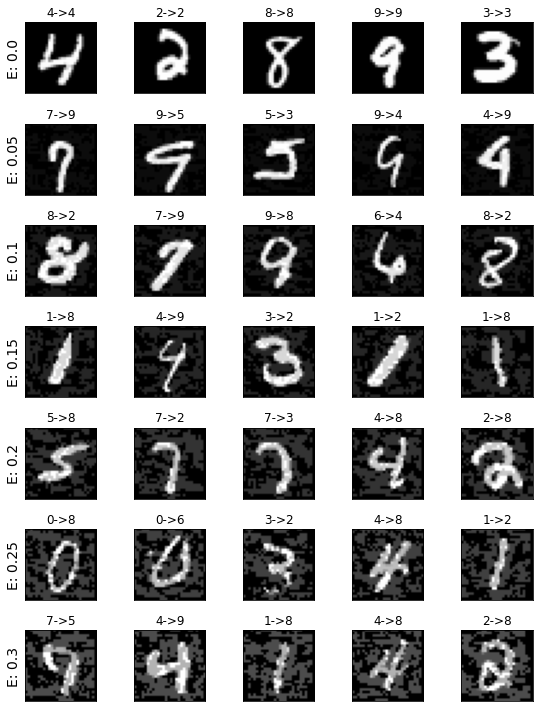

In [39]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt+=1
        plt.subplot(len(epsilons),len(examples[0]), cnt)
        plt.xticks([])
        plt.yticks([])
        if j==0:
            plt.ylabel('E: {}'.format(round(epsilons[i],2)),fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title('{}->{}'.format(orig,adv));
        plt.imshow(ex,cmap='gray')
plt.tight_layout()
plt.show()